# Ensemble Monte Carlo fitting of LG Beams

### Erik Flom, The University of Oklahoma

##### A Work in Progress: More functionality to be added soon!

## Generic Imports / Definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pylab
import pandas as pd
import pylab
import emcee
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10,10)

## Import Data

### Data are put into a single 3-D array of index:

### [NumberOfDataPoints, Y_Resolution, X_Resolution]

In [2]:
NumberOfPoints=25

LocationOnDisk="C:/Users/EFlom/Documents/Data/1-0/July_14/"
data = np.zeros([NumberOfPoints,1024,1024]) 
data_err = np.zeros([NumberOfPoints,1024,1024]) 
## 1039x1392 is the pixel size of our CCD Camera

for i in range(NumberOfPoints):
    data_string = LocationOnDisk + str(2*i+1) + "_" + "%04d" % (1) + ".asc"
    data[i,:,:] = pd.read_table(data_string, skiprows=7, nrows=1024, usecols = range(188,1212))
    data_err[i,:,:] = np.sqrt(data[i,:,:])
  
X, Y = np.meshgrid(np.arange(1,1025,1), np.arange(1,1025,1))


print("Done!")

Done!


## Generate 2D histograms of the Data (eye test)

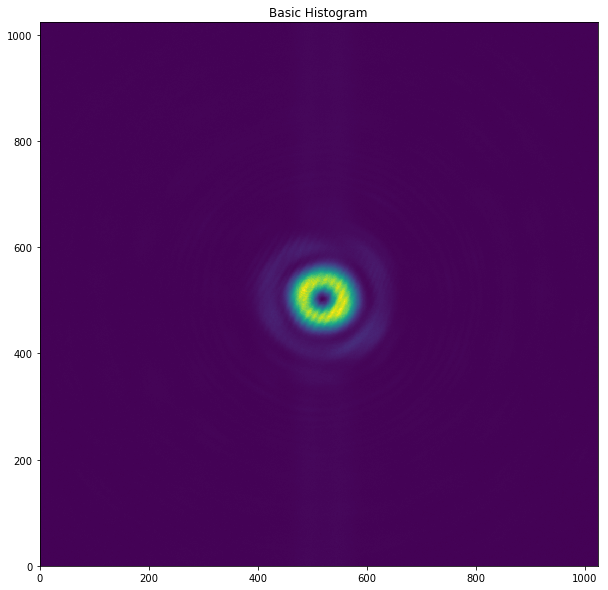

In [803]:
plt.pcolormesh(data[4,:,:], cmap='viridis')
plt.title('Basic Histogram')
plt.show()

### Plot Cross-Section of Data (eye test)

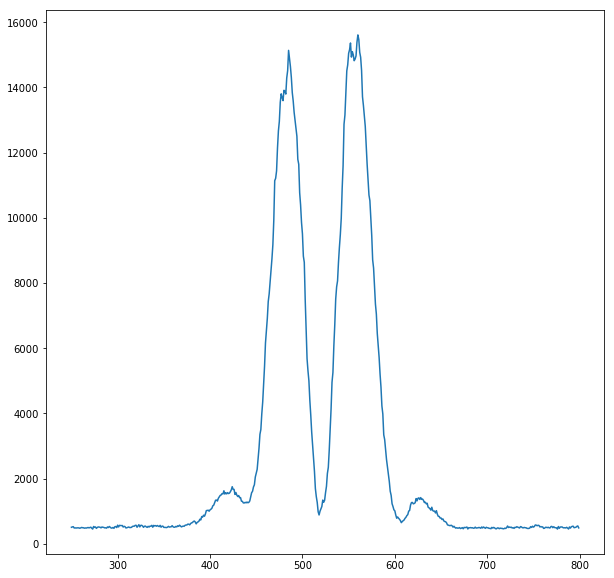

In [5]:
#This plots a cross-section at a specified y pixel row across the range of [xmin, xmax]

xmin = 250
xmax = 800
y_val = 500

cross_section = data[4, y_val, xmin:xmax]
x = np.arange(xmin, xmax, 1)
plt.plot(x, cross_section)


#  Monte Carlo Routine

## Definition of Various Beam Modes and Initial Value Guesses

In [6]:
def Mode_1_0(params):
       
    A=((params[0]**2)*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**1
    B=1.
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  
    
def Mode_2_1(params):
    
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**2
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  
    
def Mode_10_1(params):
    
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**10
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  
    
def Mode_5_0(params):
    
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**5
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  

def Mode_5_1(params):
    
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**5
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  


## Instantiation of Walkers, addition of small random initial perturbation around guesses

## Definition of Prior, Likelihood, and Posterior 

In [9]:
def log_prior(param):
    scale_min = 100.0
    scale_max = 4000.0
    width_min = 20.0
    width_max = 250.0
    baseline_min = 100.0
    baseline_max = 1200.0
    x0_min = 450.0
    x0_max = 650.0
    y0_min = 450.0
    y0_max = 650.0
        
    if ((scale_min <= param[0] <= scale_max) and
    (width_min <= param[1] <= width_max) and
    (baseline_min <= param[2] <= baseline_max)and 
    (x0_min <= param[3] <= x0_max)and 
    (y0_min <= param[4] <= y0_max)): 

        return 0.0
    
    else:
        return -np.inf


def log_likelihood(param, z, data_err):
    model = Mode_1_0(param)
    likelihood = (-0.5)*(np.sum(np.sum(((model - z)/data_err)**2))) - np.log(np.size(z))
    return likelihood

def log_posterior(param, z, data_err):
    return (log_prior(param) + log_likelihood(param, z, data_err))/(np.size(z))

## Definition of Binning Function (note: binfactor must be power of 2)

In [10]:
binfactor=4
X, Y = np.meshgrid(np.arange(1,1024 +1 ,binfactor), np.arange(1,1024 + 1,binfactor))
z = Mode_1_0(params)


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

## Definition of Main() Function -- This is what actually implements the MCMC. It is called in the next cell.

In [24]:
def Main(data_to_fit, errors_to_fit, guesses, numsims=500, burnin=250, nwalkers=100):

    ndim = 5
    
    nwalkers = 50
    
    scale_i = guesses[0]+100.0*np.random.randn(nwalkers)
    width_i = guesses[1]+5.0*np.random.randn(nwalkers)
    baseline_i = guesses[2]+30.0*np.random.randn(nwalkers)
    x0_i = guesses[3]+10.0*np.random.randn(nwalkers)
    y0_i = guesses[4]+10.0*np.random.randn(nwalkers)

    pos = [scale_i]+[width_i]+[baseline_i]+[x0_i]+[y0_i]
    posNew=(np.array(pos)).T

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_to_fit, errors_to_fit))
    %time sampler.run_mcmc(posNew, numsims) # %time is used to time this line of the function. It will print the CPU time in the output
    
    chain=sampler.chain
    lnprob=sampler.lnprobability
    acceptance=sampler.acceptance_fraction
    
    percent_regions=[1.0-0.9973,1.0-0.9545,1.0-0.6827,0.5,0.6827,0.9545,0.9973]

    confidence_regions_params=np.zeros([7,ndim])

    acceptances = [np.percentile(acceptance, 5), np.percentile(acceptance, 50), np.percentile(acceptance, 95)]
    scale = [np.percentile(chain[:,burnin:numsims,0], 5), np.percentile(chain[:,burnin:numsims,0], 50), np.percentile(chain[:,burnin:numsims,0], 95)]
    width =  [np.percentile(chain[:,burnin:numsims,1], 5), np.percentile(chain[:,burnin:numsims,1], 50), np.percentile(chain[:,burnin:numsims,1], 95)]
    background =  [np.percentile(chain[:,burnin:numsims,2], 5), np.percentile(chain[:,burnin:numsims,2], 50), np.percentile(chain[:,burnin:numsims,2], 95)]
    x0 =  [np.percentile(chain[:,burnin:numsims,3], 5), np.percentile(chain[:,burnin:numsims,3], 50), np.percentile(chain[:,burnin:numsims,3], 95)]
    y0 =  [np.percentile(chain[:,burnin:numsims,4], 5), np.percentile(chain[:,burnin:numsims,4], 50), np.percentile(chain[:,burnin:numsims,4], 95)]
    logPDF = [np.percentile(lnprob[:, burnin:numsims], 5), np.percentile(lnprob[:, burnin:numsims], 50), np.percentile(lnprob[:, burnin:numsims], 95)]
    
    
    return acceptances, scale, width, background, x0, y0, logPDF
    

## Calling the Main() within a For loop to analyze entire data series. Input initial guesses here.

In [25]:
ndim = 5
numsims = 500
binfactor=4
X, Y = np.meshgrid(np.arange(1,1024 +1 ,binfactor), np.arange(1,1024 + 1,binfactor))

guesses = [300,25,600,550,550] #guesses ONLY for first run. Everything else done recursively.

scale_i = params[0]+75.0*np.random.randn(nwalkers)
width_i = params[1]+5.0*np.random.randn(nwalkers)
baseline_i = params[2]+50.0*np.random.randn(nwalkers)
x0_i = params[3]+20.0*np.random.randn(nwalkers)
y0_i = params[4]+20.0*np.random.randn(nwalkers)

acceptances = np.zeros((NumberOfPoints,3))
scales = np.zeros((NumberOfPoints,3))
widths = np.zeros((NumberOfPoints,3))
backgrounds = np.zeros((NumberOfPoints,3))
x0s = np.zeros((NumberOfPoints,3))
y0s = np.zeros((NumberOfPoints,3))
logPDFs = np.zeros((NumberOfPoints,3))

for i in range(NumberOfPoints):
    
    data_new = rebin(data[i,:,:], (1024/binfactor,1024/binfactor))
    err_new = rebin(data_err[i,:,:], (1024/binfactor,1024/binfactor))
    
    acceptances[i,:], scales[i,:], widths[i,:], backgrounds[i,:], x0s[i,:], y0s[i,:], logPDFs[i,:] = Main(data_new, err_new, guesses, numsims=300, burnin=200, nwalkers=50)
    
    guesses[1] = guesses[1] + 6
    

    

Wall time: 57.6 s
Wall time: 52 s
Wall time: 55.3 s
Wall time: 50.2 s
Wall time: 1min 8s
Wall time: 34.7 s
Wall time: 37.5 s
Wall time: 38.3 s
Wall time: 37.7 s
Wall time: 38.6 s
Wall time: 37.8 s
Wall time: 38.1 s
Wall time: 37.7 s
Wall time: 48.1 s
Wall time: 51.1 s
Wall time: 49.9 s
Wall time: 58.2 s
Wall time: 55.2 s
Wall time: 36.4 s
Wall time: 43.7 s
Wall time: 33.1 s
Wall time: 32.2 s
Wall time: 34.8 s
Wall time: 32.5 s
Wall time: 31.1 s


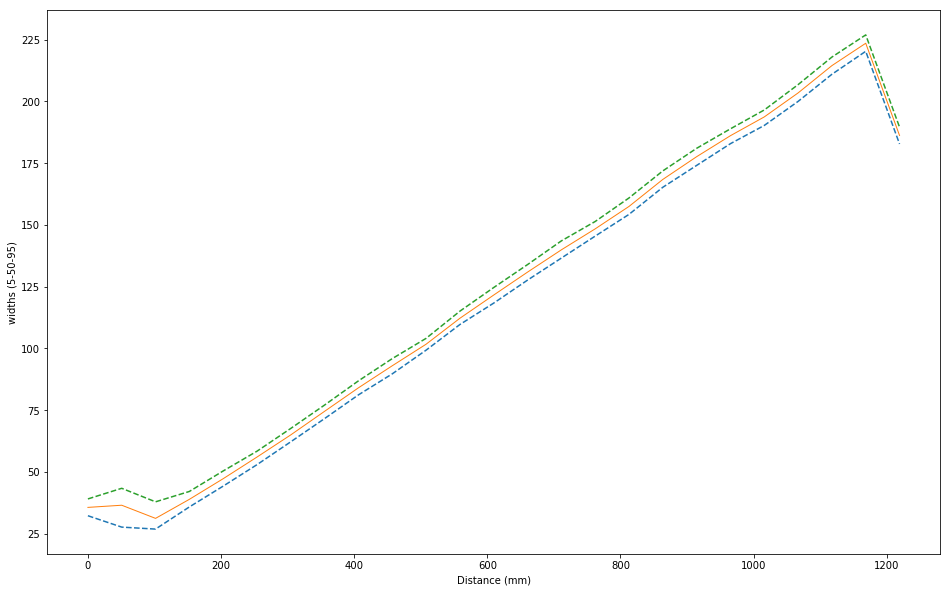

In [29]:
pylab.rcParams['figure.figsize'] = (16,10)
plt.plot(np.arange(25)*50.8,widths[:,0], ls="--")
plt.plot(np.arange(25)*50.8,widths[:,1], lw = 1)
plt.plot(np.arange(25)*50.8,widths[:,2], ls='--')
plt.xlabel('Distance (mm)')
plt.ylabel('widths (5-50-95)')

In [953]:
widths

array([[ 111.96123562,  140.29022375,  162.78299456],
       [ 102.72183659,  121.99265181,  157.69770549],
       [ 116.58311878,  159.91340047,  194.64165731],
       [ 152.10139324,  178.6693705 ,  199.05677452],
       [ 170.09834652,  192.83023389,  211.26677879],
       [ 160.48037198,  177.15070414,  192.57120503],
       [ 172.99727243,  187.06979819,  199.08323023],
       [ 169.05169938,  180.6307075 ,  193.06239557],
       [ 176.67646801,  186.12317948,  195.56479103],
       [ 167.70036488,  176.21748789,  185.00512771],
       [ 169.88610241,  178.19037838,  186.32841709],
       [ 173.28035232,  180.67026655,  187.77102043],
       [ 165.40818863,  173.11028393,  179.88991311],
       [ 174.31137335,  180.82495061,  187.41537479],
       [ 172.97223927,  178.87131379,  184.7811185 ],
       [ 164.77438013,  169.96640929,  175.57532629],
       [ 158.47907351,  164.75040023,  170.107714  ],
       [ 171.82106055,  177.43001374,  182.74932825],
       [ 159.90835079,  164.

## Plot Histograms of Parameters

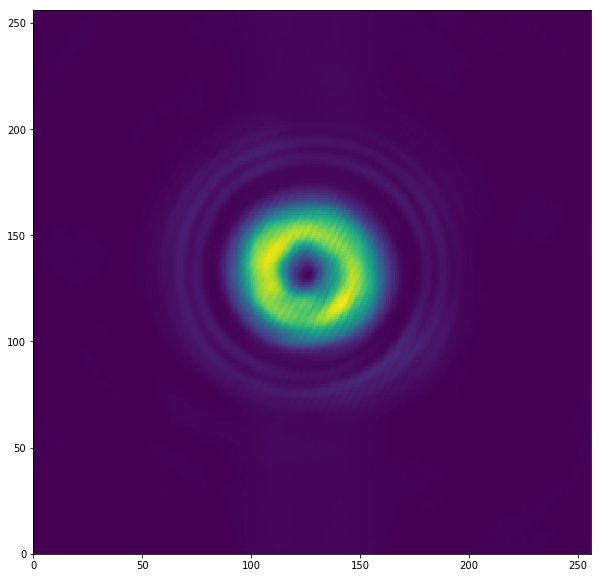

In [822]:
z = Mode_1_0(params)
            
pylab.rcParams['figure.figsize'] = (10,10)            
plt.pcolormesh(data_new, cmap='viridis')

(100L, 10L, 5L)
(100L, 10L)
(100L,)


(50L, 500L, 5L)
(50L, 500L)
(50L,)


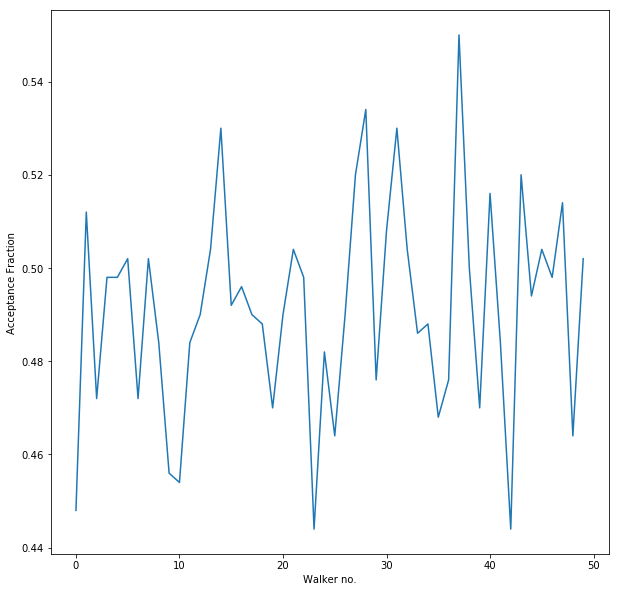

In [823]:
chain = sampler.chain
lnprob=sampler.lnprobability
acceptance=sampler.acceptance_fraction

print chain.shape
print lnprob.shape
print acceptance.shape

plt.plot(acceptance)
plt.xlabel('Walker no.')
plt.ylabel('Acceptance Fraction')

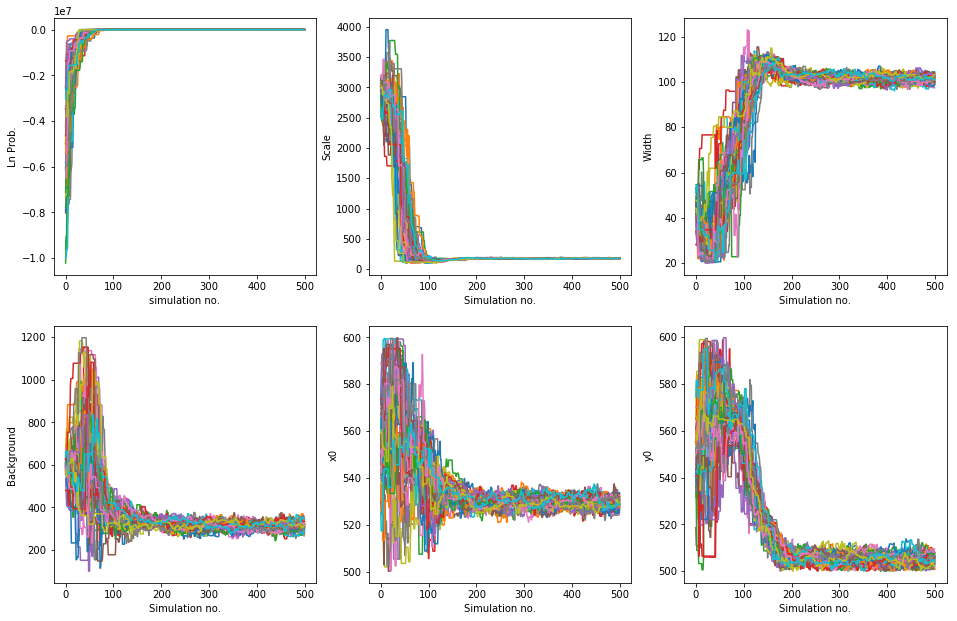

In [824]:
index = np.arange(numsims)
from matplotlib import pyplot
pylab.rcParams['figure.figsize'] = (16,10.39)
for i in range(nwalkers):
    pyplot.subplot(2,3,1)
    plt.plot(index, lnprob[i, 0:numsims])
    plt.xlabel('simulation no.')
    plt.ylabel('Ln Prob.')
    
    pyplot.subplot(2,3,2)
    plt.plot(index, chain[i,0:numsims,0])
    plt.xlabel('Simulation no.')
    plt.ylabel('Scale')
    
    pyplot.subplot(2,3,3)
    plt.plot(index, chain[i,0:numsims,1])
    plt.xlabel('Simulation no.')
    plt.ylabel('Width')
    
    pyplot.subplot(2,3,4)
    plt.plot(index, chain[i,0:numsims,2])
    plt.xlabel('Simulation no.')
    plt.ylabel('Background')
    
    pyplot.subplot(2,3,5)
    plt.plot(index, chain[i,0:numsims,3])
    plt.xlabel('Simulation no.')
    plt.ylabel('x0')
    
    pyplot.subplot(2,3,6)
    plt.plot(index, chain[i,0:numsims,4])
    plt.xlabel('Simulation no.')
    plt.ylabel('y0')
    
plt.show()
    

(50L, 500L, 5L)
(12500L,)
(12500L, 5L)
-39.2325222235


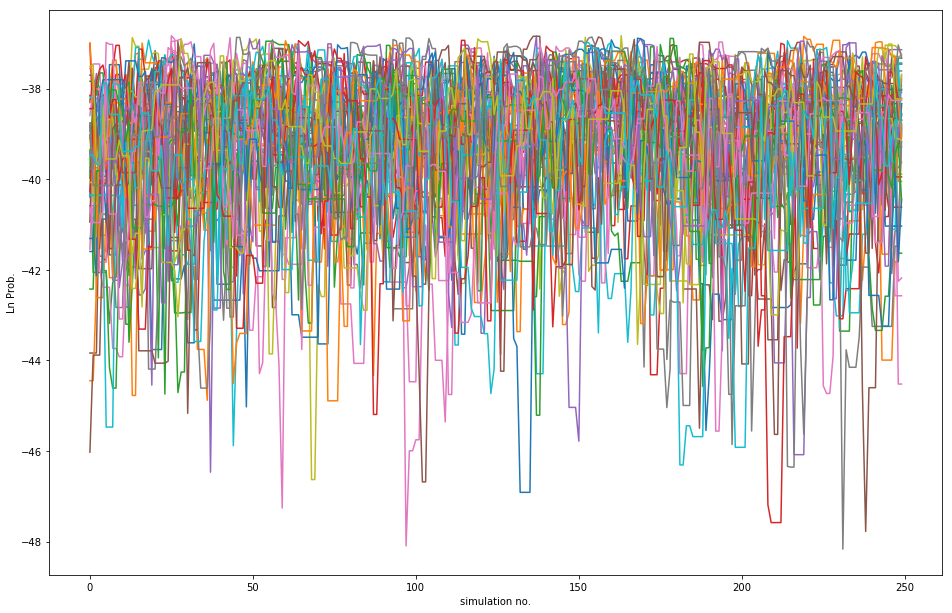

In [839]:
def MakeHistogram(samples, index, numbins):
    numout=len(samples)
    comp=samples[0:numout,index]
    comp_histogram=np.array(np.histogram(comp,bins=numbins,range=[comp.min(),comp.max()]))
    comp_histogram_y=comp_histogram[0]
    temp=comp_histogram[1]
    binsize=temp[1]-temp[0]
    comp_histogram_x=comp.min()+0.5*binsize+binsize*np.arange(numbins)
    return comp_histogram_x,comp_histogram_y

print chain.shape
burnin=250
ndim=chain.shape[2]

for i in range(nwalkers):
    plt.plot(np.arange(numsims-burnin), lnprob[i, burnin:numsims])
    plt.xlabel('simulation no.')
    plt.ylabel('Ln Prob.')

lnprob2=lnprob[:,burnin:].reshape((-1))
temp=chain[:,burnin:,0:ndim]
sample=temp.reshape(((numsims-burnin)*nwalkers,ndim))

print lnprob2.shape
print sample.shape
print np.mean(lnprob[:, burnin:numsims])

## Make Histogram of Scaling Factor

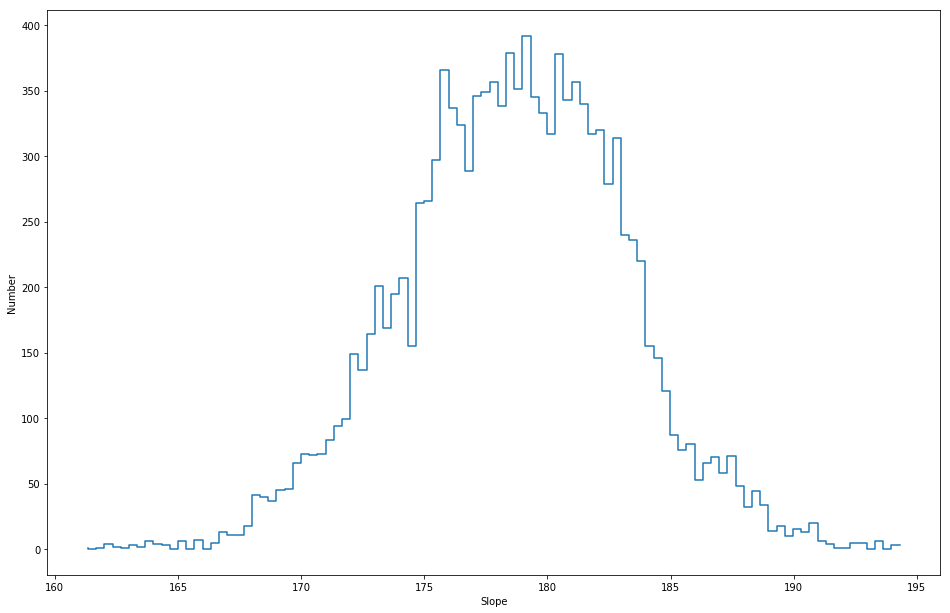

In [828]:
index=0
numbins = 100
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('Slope')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

## Make Histogram of Width

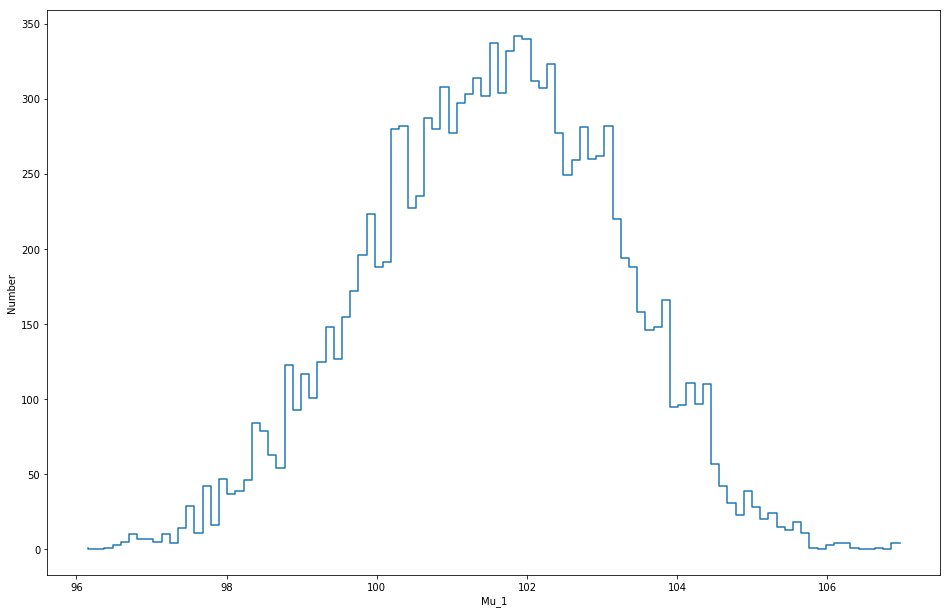

In [829]:
index=1
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('Mu_1')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

## Make Histogram of Baseline

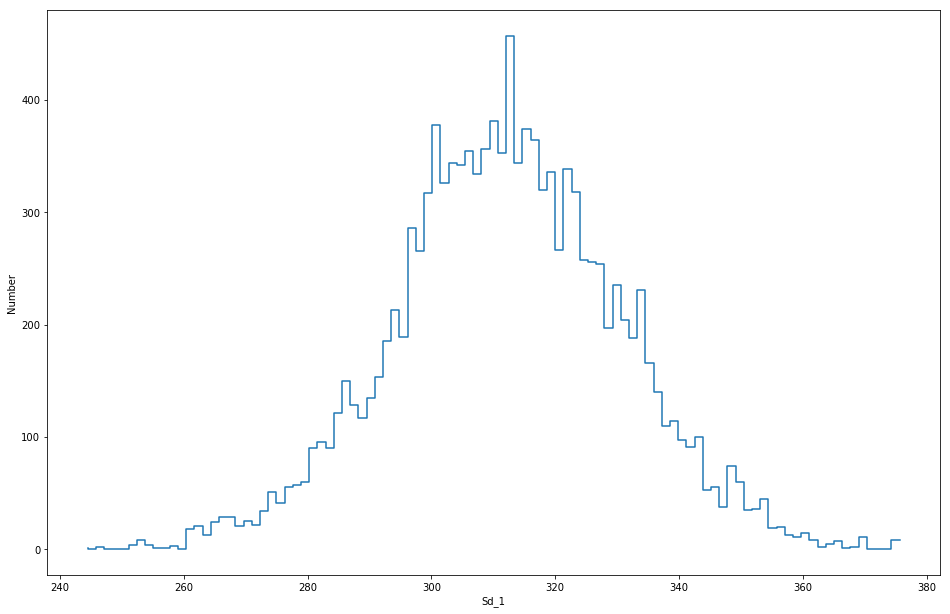

In [830]:
index=2
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('Sd_1')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

## Make Histogram of x0

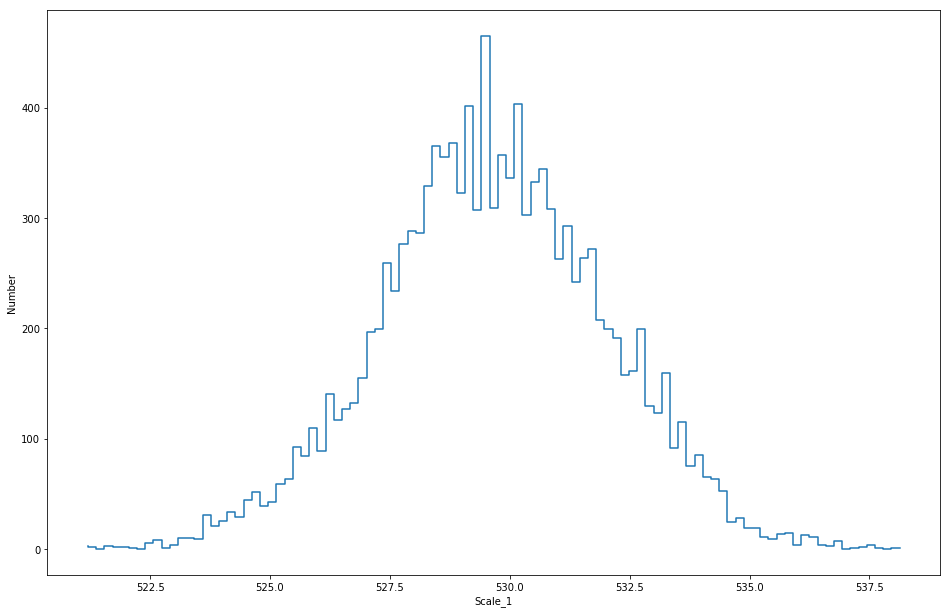

In [831]:
index=3
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('Scale_1')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

## Make Histogram of y0

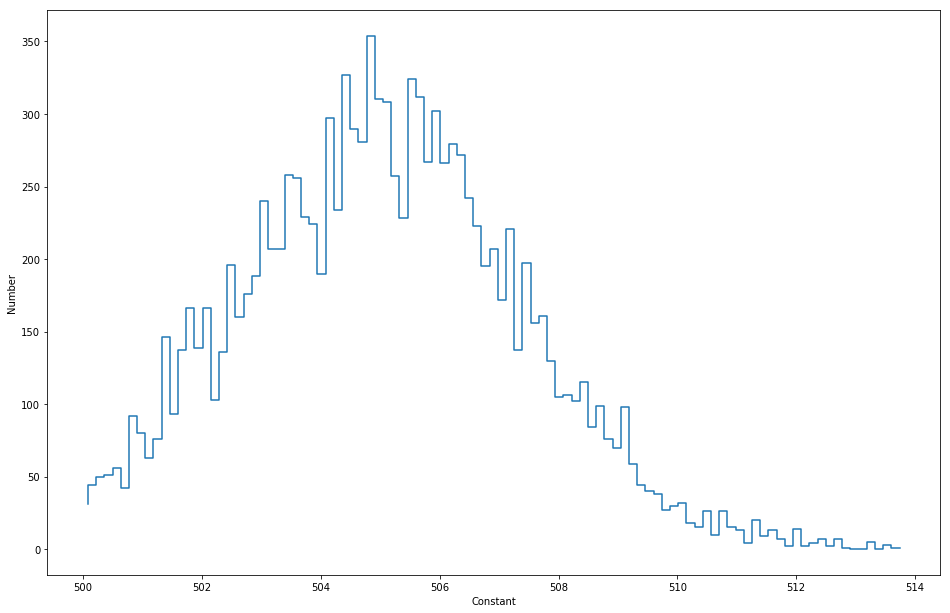

In [832]:
index=4
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('Constant')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

In [767]:
percent_regions=[1.0-0.9973,1.0-0.9545,1.0-0.6827,0.5,0.6827,0.9545,0.9973]

confidence_regions_params=np.zeros([7,ndim])

numsamples=len(sample)

for i in np.arange(ndim):
    temp=sample[:,i]
    x2=np.sort(temp)
    f2=np.array(range(numsamples))/float(numsamples)
    confidence_regions_params[0:7,i]=np.interp(percent_regions,f2,x2)

print 'The median value of Scale is ',confidence_regions_params[4,0], ' 95% interval:', [confidence_regions_params[1,0],confidence_regions_params[6,0]]
print 'The median value of Width is ',confidence_regions_params[4,1], '   95% interval:', [confidence_regions_params[1,1],confidence_regions_params[6,1]]
print 'The median value of Baseline is ',confidence_regions_params[4,2], '  95% interval:', [confidence_regions_params[1,2],confidence_regions_params[6,2]]
print 'The median value x0 is ',confidence_regions_params[4,3], '  95% interval:', [confidence_regions_params[1,3],confidence_regions_params[6,3]]
print 'The median value of y0 is ',confidence_regions_params[4,4], '  95% interval:', [confidence_regions_params[1,4],confidence_regions_params[6,4]]


The median value of Scale is  3000.04212528  95% interval: [2999.7805395666992, 3000.3356990021598]
The median value of Width is  95.0019126965    95% interval: [94.994199183490238, 95.009145639001332]
The median value of Baseline is  607.539784158   95% interval: [571.00824661489719, 644.49060991990609]
The median value x0 is  550.001849215   95% interval: [549.99241526369326, 550.01210930986349]
The median value of y0 is  550.001730619   95% interval: [549.99263053533173, 550.01095169988253]


## Plot Redisuals

-15.8569274104


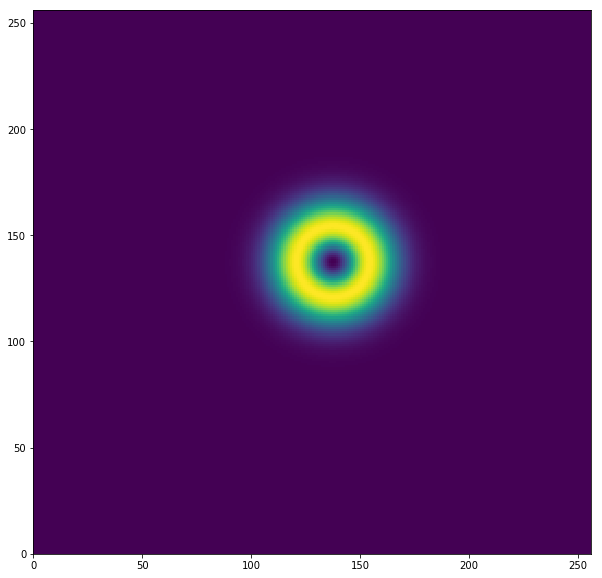

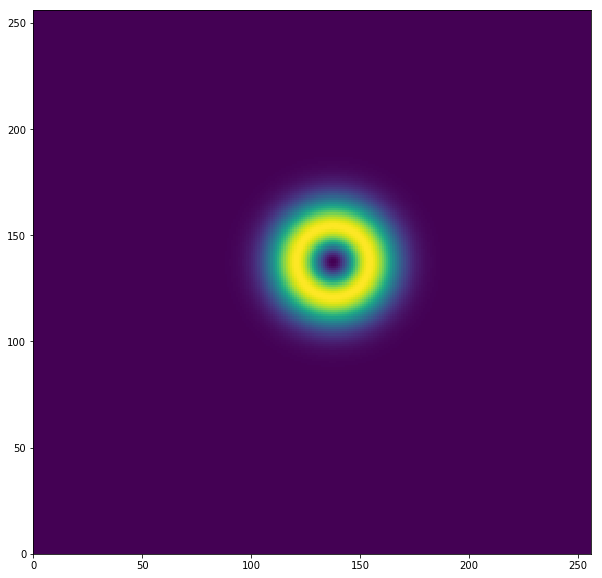

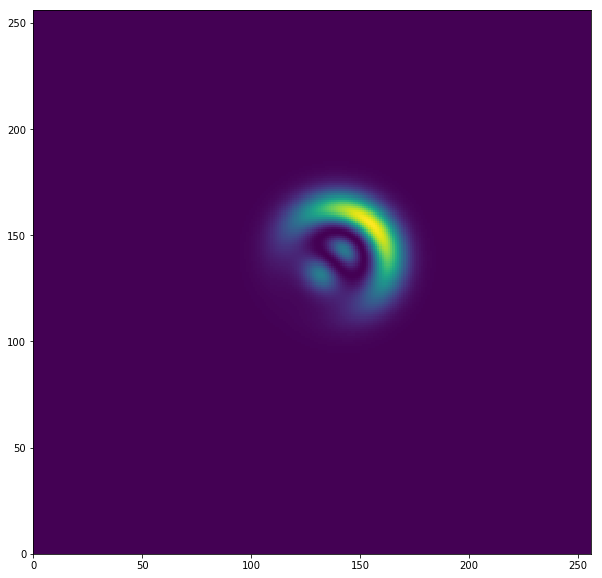

In [769]:
fitted_params=confidence_regions_params[4,:]
fitted_curve=Mode_1_0(fitted_params)

pylab.rcParams['figure.figsize'] = (10,10) 

print(np.sum(np.sum(data_new-fitted_curve))/256**2)
plt.pcolormesh(data_new)
plt.show()
plt.pcolormesh(fitted_curve)
plt.show()
plt.pcolormesh((data_new-fitted_curve)**2, cmap='viridis')
plt.show()